# Web Scraping

Lots of great data is available online, but available through inconveniently formatted web pages. When this is the case, sometimes you can simply copy and paste the data into a .csv file and go on with your life. But if there are many records to parse and combine into a dataset, that might be impossible. Can we automate the collection of data from online sources?

This is called web scraping. Broadly speaking: Web scraping is legal, but what you plan to do with the results of your scraping might not be. In general, most sites do not want you to scrape them at this point, but there is not really a way to stop you if you are sufficiently motivated. Be careful to use server resources respectfully (not too many requests per unit time), think seriously about privacy concerns, and be careful who you share your work with and how it is used. be an ethical human being basically. but some people can't afford to even do that

We'll be scraping data about used cars in Charlottesville from Craigslist, particularly this page: https://charlottesville.craigslist.org/search/cta?purveyor=owner#search=1~gallery~0~0 

We'll use the `requests` package to get web pages off the Internet and into Python. Again, we'll use a header with a user-agent that masks our true identity so that we're not rejected by the server. This particular url points to the car listings for Craigslist in Charlottesville. To use requests, you pass a `url` for the page you want and a `header` that controls how you appear to the server to `requests.get`:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import requests # Page requests

header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'} # How we wish to appear to CL
url = 'https://charlottesville.craigslist.org/search/cta?purveyor=owner#search=1~gallery~0~0' # The page we want to scrape
raw = requests.get(url,headers=header) # Get page

/usr/lib/python3/dist-packages/pytz/__init__.py:31: SyntaxWarning: invalid escape sequence '\s'
  match = re.match("^#\s*version\s*([0-9a-z]*)\s*$", line)


Now that we have that particular page available locally, we want to **parse** it and get results from it. To do that, we can use a package called `beautifulSoup` or `bs4`.

What does `beautifulSoup` do for us? Let's go to the web page of interest. You probably see something like this:

![Listings](./src/craigslist.png "Craigslist")

But if you "view page source" -- which is CTRL+U -- in Chrome, you see what the computer sees:

![Listings](./src/craigslist_source.png "Craigslist")

Since your web browser needs lots of instructions about how to render the text, pictures, and other content on your web page, there are a lot of clues about where the data live and how to extricate them from a page. These clues are called **tags**. If you wander the source for the search page on cars, you see a particular `class = "cl-static-search-result"` term appear attached to each listing:

![Listings](./src/listing.png "Craigslist")

This structure can be exploited to search the page for information. This kind of detective work -- looking at the page source, finding the interesting tags, and then searching the page with `beautifulSoup` -- is the basic job of web scraping.

What I do is look at the rendered page, find the text I want and copy it, then search for that text in the HTML code that the computer sees. When I find the text I want, I look for the tag nearby. Here, it's `cl-static-search-result`: That's what I'll want beautifulSoup to search for.

The following code chunk takes the raw content from `requests` and turns it into a beautifulSoup object, which can search the page and return results for us:

In [2]:
from bs4 import BeautifulSoup as soup # HTML parser
bsObj = soup(raw.content,'html.parser') # Parse the html
listings = bsObj.find_all(class_="cl-static-search-result") # Find all listings of the kind we want

Why is the argument `class_` and not just `class`? The word `class` is a reserved keyword for Python, and cannot be used by anyone else, similar to `True` and `False`. But since we want the `class = "cl-static-search-result"` terms, we need to use the `class_` argument to the `.find_all` method.

The `.find_all` function dredges the entire page and finds all the instances of `class = "cl-static-search-result"`, resulting in a list of entries. We can then parse the entries.

Parsing the entries can be a challenge! We have to go back to what a listing looks like, and look at the tags within the listing. They're typically `div` tags with a `class` like price or location. You then have to experiment a bit with `.find` and the HTML to make sure you're getting the information you want. For each listing, the `.find` method to search within the listing record for specific information, but it's typically still wrapped in the tag. To get the real information we want, we can then use `.get_text()`. I end up using a code chunk to experiment and play with a record to make sure I'm getting as close to what I want as possible.

In the code below, two more things happen. You don't need to do them in your work, but they're helpful to know about.

First, I would like to get the brand of the car from the post title, if possible. To do this, I split the title into words using `title.split()`, and then I use a list comprehension to look over every word in the title and check whether it appears in the `brands` list.

Second, I would like to get the year the car was built, if possible, so I can determine the vehicle's age. To do this, I use a thing called **regular expressions** that provides a language for expressing patterns. Do I remember how to do this off the top of my head? No, I read a few pages in a book and looked on StackOverflow for answers. Roughly, in order to express the idea "any year starting with 20xx," you can write `20[0-9][0-9]`, and for "any year starting with 19xx," you can write `19[0-9][0-9]`. The `[0-9]`'s act as wildcards for any digit. This allows me to use the `re` package to find any instances of year-like numbers in the title text, using `re.search(r'20[0-9][0-9]|19[0-9][0-9]', title )`.

This is all nested in a for-loop over the listings, and the data is appended to a list.

In [3]:
import re # Regular expressions

brands = ['honda', 'dodge','toyota','ford','tesla','gmc','jeep','bmw','mitsubishi','mazda',
          'volvo','audi','volkswagen','chevy','chevrolet','acura','kia','subaru','lexus',
          'cadillac','buick','porsche','infiniti']

data = [] # We'll save our listings in this object
for k in range( len(listings) ):
    title = listings[k].find('div',class_='title').get_text().lower()
    price = listings[k].find('div',class_='price').get_text()
    link = listings[k].find(href=True)['href']
    # Get brand from the title string:
    words = title.split()
    hits = [word for word in words if word in brands] # Find brands in the title
    if len(hits) == 0:
        brand = 'missing'
    else:
        brand = hits[0]
    # Get years from title string:
    regex_search = re.search(r'20[0-9][0-9]|19[0-9][0-9]', title ) # Find year references
    if regex_search is None: # If no hits, record year as missing value
        year = np.nan
    else: # If hits, record year as first match
        year = regex_search.group(0)
    #
    data.append({'title':title,'price':price,'year':year,'link':link,'brand':brand})


With the data scraped from Craigslist, we can put it in a dataframe and wrangle it. Of course, price and year come in as text, not numbers, and need to be typecast/coerced:

In [4]:
## Wrangle the data
df = pd.DataFrame.from_dict(data)
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'],errors='coerce')
df['year'] = pd.to_numeric(df['year'],errors='coerce')
df['age'] = 2025-df['year']
print(df.shape)
df.head()

(72, 6)


,title,price,year,link,brand,age
0,2006 toyota matrix for sale,2000,2006.0,https://charlottesville.craigslist.org/cto/d/c...,toyota,19.0
1,2017 mazda cx-3 sport,10500,2017.0,https://charlottesville.craigslist.org/cto/d/c...,mazda,8.0
2,2005 bmw m3 project,5000,2005.0,https://charlottesville.craigslist.org/cto/d/c...,bmw,20.0
3,2000 jeep grand cherokee,900,2000.0,https://charlottesville.craigslist.org/cto/d/p...,jeep,25.0
4,2009 jeep commander for sale,2000,2009.0,https://charlottesville.craigslist.org/cto/d/c...,jeep,16.0


With the data in and wrangled, we can now do some analysis:

count       72.000000
mean     10081.250000
std      11468.491549
min        900.000000
25%       3237.500000
50%       6375.000000
75%      12000.000000
max      62800.000000
Name: price, dtype: float64


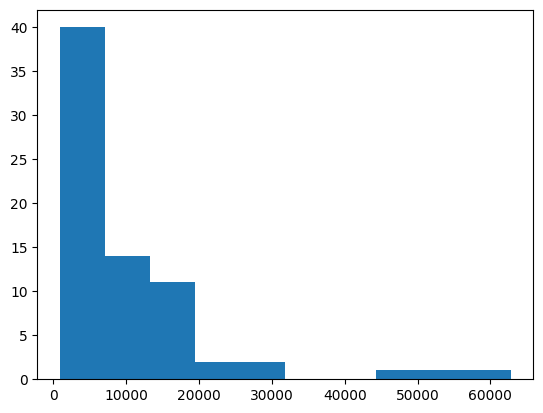

count    68.000000
mean     21.117647
std      14.834942
min       3.000000
25%      12.750000
50%      17.000000
75%      22.500000
max      68.000000
Name: age, dtype: float64


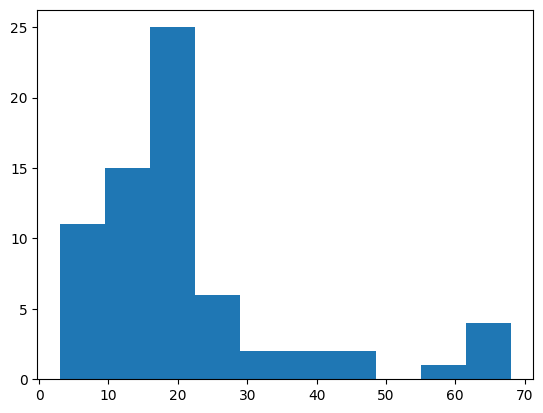

In [5]:
print(df['price'].describe())
df['price'].hist(grid=False)
plt.show()
print(df['age'].describe())
df['age'].hist(grid=False)
plt.show()

In [6]:
# Price by brand:
df.loc[:,['price','brand']].groupby('brand').describe()

price                                                         \
           count          mean           std      min      25%      50%   
brand                                                                     
acura        2.0   3250.000000   1767.766953   2000.0   2625.0   3250.0   
audi         2.0  12250.000000   1767.766953  11000.0  11625.0  12250.0   
bmw          3.0   8500.000000   3041.381265   5000.0   7500.0  10000.0   
buick        1.0   6000.000000           NaN   6000.0   6000.0   6000.0   
cadillac     1.0   2950.000000           NaN   2950.0   2950.0   2950.0   
chevrolet    4.0  16350.000000   9082.400564   4900.0  12100.0  17000.0   
chevy        4.0   7512.500000   5970.814434   2200.0   2725.0   6675.0   
dodge        4.0   4387.500000   3723.881264   1500.0   2100.0   3150.0   
ford         6.0  15966.666667  17563.219143   1000.0   5375.0  11650.0   
honda        8.0  11500.000000   8705.991369   3000.0   5600.0   8450.0   
jeep         5.0   6530.000000   6799.227897    900.0   2000.0   5500.0   
kia          3.0   8266.666667   6689.045772   2500.0   4600.0   6700.0   
mazda        1.0  10500.000000           NaN  10500.0  10500.0  10500.0   
missing     16.0  11631.250000  18653.890345   2000.0   3137.5   4375.0   
mitsubishi   1.0   6800.000000           NaN   6800.0   6800.0   6800.0   
subaru       1.0   5300.000000           NaN   5300.0   5300.0   5300.0   
tesla        1.0  25000.000000           NaN  25000.0  25000.0  25000.0   
toyota       6.0   7583.333333   5392.371154   2000.0   3700.0   6550.0   
volkswagen   3.0   7650.000000   5810.980984   2500.0   4500.0   6500.0   

                              
                75%      max  
brand                         
acura        3875.0   4500.0  
audi        12875.0  13500.0  
bmw         10250.0  10500.0  
buick        6000.0   6000.0  
cadillac     2950.0   2950.0  
chevrolet   21250.0  26500.0  
chevy       11462.5  14500.0  
dodge        5437.5   9750.0  
ford        16950.0  49500.0  
honda       15125.0  29000.0  
jeep         6250.0  18000.0  
kia         11150.0  15600.0  
mazda       10500.0  10500.0  
missing      7750.0  62800.0  
mitsubishi   6800.0   6800.0  
subaru       5300.0   5300.0  
tesla       25000.0  25000.0  
toyota      10000.0  16500.0  
volkswagen  10225.0  13950.0

In [7]:
# Age by brand:
df.loc[:,['age','brand']].groupby('brand').describe()

age                                                      
           count       mean        std   min    25%   50%    75%   max
brand                                                                 
acura        2.0  16.500000   3.535534  14.0  15.25  16.5  17.75  19.0
audi         2.0   7.500000   0.707107   7.0   7.25   7.5   7.75   8.0
bmw          3.0  17.000000   3.000000  14.0  15.50  17.0  18.50  20.0
buick        1.0  18.000000        NaN  18.0  18.00  18.0  18.00  18.0
cadillac     1.0  19.000000        NaN  19.0  19.00  19.0  19.00  19.0
chevrolet    4.0  41.250000  19.619293  21.0  32.25  38.0  47.00  68.0
chevy        3.0  17.666667   8.020806  10.0  13.50  17.0  21.50  26.0
dodge        4.0  24.500000   6.244998  17.0  20.75  25.0  28.75  31.0
ford         6.0  16.333333   5.428321   9.0  12.50  17.0  20.75  22.0
honda        8.0  10.375000   5.449443   3.0   7.00  10.5  13.50  19.0
jeep         5.0  17.800000   5.069517  13.0  14.00  16.0  21.00  25.0
kia          3.0  11.000000   7.211103   3.0   8.00  13.0  15.00  17.0
mazda        1.0   8.000000        NaN   8.0   8.00   8.0   8.00   8.0
missing     13.0  34.461538  21.512072   7.0  18.00  24.0  55.00  68.0
mitsubishi   1.0  17.000000        NaN  17.0  17.00  17.0  17.00  17.0
subaru       1.0  10.000000        NaN  10.0  10.00  10.0  10.00  10.0
tesla        1.0   7.000000        NaN   7.0   7.00   7.0   7.00   7.0
toyota       6.0  19.166667   4.400758  12.0  17.50  20.0  21.00  25.0
volkswagen   3.0  25.333333  17.243356  10.0  16.00  22.0  33.00  44.0

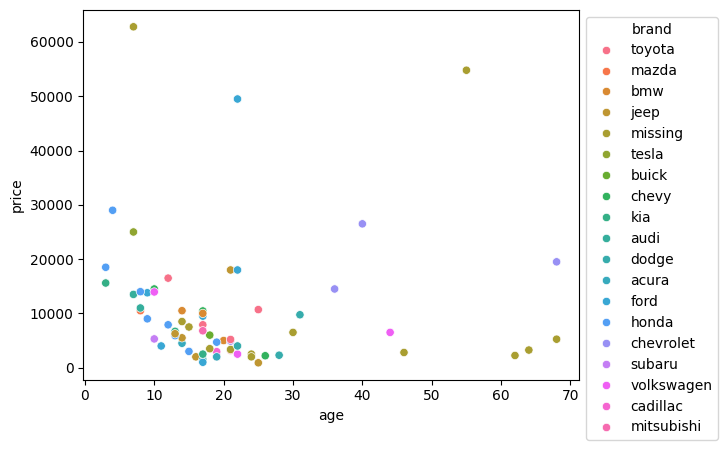

In [8]:
ax = sns.scatterplot(data=df, x='age', y='price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

           log_price   log_age
log_price   0.827613 -0.179606
log_age    -0.179606  0.428671
           log_price   log_age
log_price   1.000000 -0.296476
log_age    -0.296476  1.000000


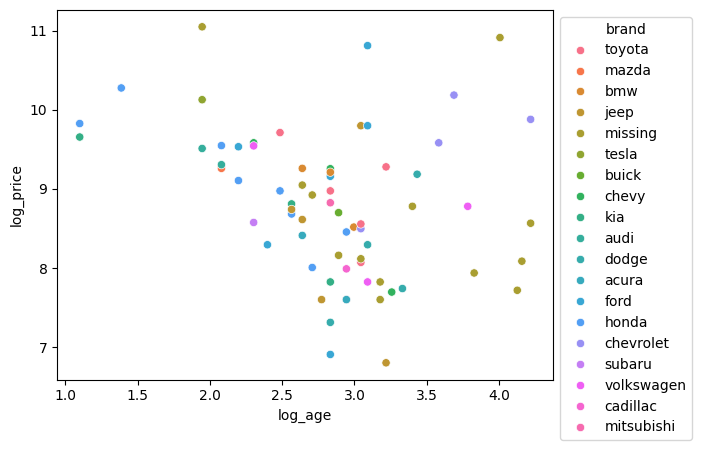

In [9]:
df['log_price'] = np.log(df['price'])
df['log_age'] = np.log(df['age'])

ax = sns.scatterplot(data=df, x='log_age', y='log_price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

print(df.loc[:,['log_price','log_age']].cov())
print(df.loc[:,['log_price','log_age']].corr())

## The Lab:


1. Pick something else on Craigslist besides used cars: Musical instruments, roommates, antiques, etc. Look at the search page and its source code. Record which fields/data you would like to gather, and what kinds of basic EDA you'd do with it.
2. Get your search results of interest using `requests` and extract data from them using `beautifulSoup`, using code similar to what's above.
3. Wrangle your data into a dataframe and do some basic descriptions and plots. Try to find some interesting relationships or stories to tell about your data.

#### Part one
- I am interested in looking at computer parts on Craigslist (thought it'd be apt to look at technology while doing work for a technology course).
- Source code ain't too intimidating. I have some basic familiarity with HTML from the time I attempted a janky Neocities site. There is a LOT of code dedicated to formatting - this will basically be junk when time comes for us to clean our data. I am interested in looking at different pieces of hardware and surveying what is available - drives, fans, towers, ink cartrages, keyboards, mice, switches, adapters, extra RAM, monitors, speakers, others. 
- When people are willing to give away a piece of technology on Craigslist, does it speak to its longevity? Or does it speak to its utility to a given person? Maybe by poking around at data about what's for sale, we can draw conclusions about what motivates people to sell their junk. (Or - we can draw conclusions about certain computer parts' characteristics.) 
- link to the page: https://charlottesville.craigslist.org/search/syp#search=1~gallery~0~0

#### Part two 
The code can be viewed below. 

In [10]:
# the code below helps us pretend that our webscraper is 
# a normal human being. just doing normal human things 
header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'} # How we wish to appear to CL
# the page we will scrape. 
# different url than the one in the example. 
url = 'https://charlottesville.craigslist.org/search/syp?purveyor=owner#search=1~gallery~0~0' # The page we want to scrape
raw = requests.get(url,headers=header) # Get page

In [11]:
from bs4 import BeautifulSoup as bs # HTML parser
bsObj = bs(raw.content,'html.parser') # Parse the html
listings = bsObj.find_all(class_="cl-static-search-result") # Find all listings of the kind we want

In [12]:
# much of this is copy-pasted from the original codebook, but i...
# ...am going to comment out things so you can tell i am thinking...
# ...about what i am doing. 

# The types of items we are looking for 
items = ["drive", "fan", "tower", "ink", "keyboard", "mouse", "switch", 
         "adapter", "RAM", "monitor", "speaker", "plate", "riser", "gpu", "toner",
        "case"]

# list we are storing data in. 
data = []
# for each listing, we will do the following: 
for k in range( len(listings) ):
    # take the title of the listing (i.e. the name the seller gave...
    # ...to the item) and make it all lowercase so the computer...
    # ...doesn't mistaken a capitalised version of a word for an entirely...
    # ...different word. 
    title = listings[k].find('div',class_='title').get_text().lower()
    # fetch the price. this will hopefully be interpreted as...
    # ...a numeric value. 
    price = listings[k].find('div',class_='price').get_text()
    # splitting up each word in the title into several smaller strings 
    words = title.split()
    # a 'hit' will be when we see a word in the 'items' list on our...
    # ...site. 
    hits = [word for word in words if word in items] 
    # if we can't find any of the items we are looking for, we will just say...
    # ...they are 'other'. 
    if len(hits) == 0:
        item = 'other'
    # if we can find the item...
    else:
        item = hits[0]
    # something that i also want to do is take a looksie at the different...
    # ...conditions of these items. 
    # yoinking the hyperlink to the listing 
    link = listings[k].find(href=True)['href']
    # going into the list and peeking at the 'condition' data
    data.append({'title':title,'price':price,'link':link,'item':item})

# unlike the case with the vehicles examples, i am not interested in years...
# ...pieces of technology were released. 
# from a cursory glance at the listings, there is not enough year data to...
# ...conduct meaningful EDA with.  
# that's why i chose to look at quality of the items!

# testing 123
df = pd.DataFrame.from_dict(data)
df.head()

,title,price,link,item
0,usb keyboard and mouse combo,$25,https://charlottesville.craigslist.org/sop/d/c...,keyboard
1,j5create usb to vga adapter plus vga cable,$25,https://charlottesville.craigslist.org/sop/d/c...,adapter
2,dell desktop computer speakers,$20,https://charlottesville.craigslist.org/sop/d/c...,other
3,"tripods for camera, corners, video etc",$15,https://charlottesville.craigslist.org/sop/d/c...,other
4,aicheson s-035 laptop cooling fan,$25,https://charlottesville.craigslist.org/sop/d/c...,fan


In [13]:
# https://www.geeksforgeeks.org/how-to-scrape-multiple-pages-of-a-website-using-python/
# list that we store our different conditions in 
conditions = []
# turning all the objects in our 'link' column to a list we can iterate over. 
all_links = df["link"].to_list()
# for every link that we see in the link column, 
for url in range(len(all_links)):
    # we will request.get that specific link. 
    req = requests.get(all_links[url])
    # we will use the html parser on that specific link. 
    soup = bs(req.text, 'html.parser')
    condition_div = soup.find('div',class_="attr condition")
    #chatgpt helped me on what is below :(
    if condition_div:
        condition = condition_div.get_text(strip=True)
    else:
        condition = "Not Found"  # Or any default value you prefer
    # not chatgpt
    conditions.append({'attr condition':f"{condition.lstrip("condition:")}"})

# other changes made by chatgpt from my original code: 
    # bs.find to soup.find 
    # get_text to .get_text(strip=True)
    # 'attr condition':attr condition to 'attr condition':condition (this was... 
    # ...truly on me i should have known that i put the variable i named after...
    # ...the class name
conditions[0:5] # our list works. now let's append it to the rest of the dataframe 

[{'attr condition': 'like new'},
 {'attr condition': 'excellent'},
 {'attr condition': 'like new'},
 {'attr condition': 'like new'},
 {'attr condition': 'like new'}]

In [14]:
# append list to a dataframe 
conditions = pd.DataFrame(conditions)
conditions.head()

,attr condition
0,like new
1,excellent
2,like new
3,like new
4,like new


In [15]:
# attach this list to our existing dataframe 
df["condition"] = conditions
df.head()
# yay it works 

,title,price,link,item,condition
0,usb keyboard and mouse combo,$25,https://charlottesville.craigslist.org/sop/d/c...,keyboard,like new
1,j5create usb to vga adapter plus vga cable,$25,https://charlottesville.craigslist.org/sop/d/c...,adapter,excellent
2,dell desktop computer speakers,$20,https://charlottesville.craigslist.org/sop/d/c...,other,like new
3,"tripods for camera, corners, video etc",$15,https://charlottesville.craigslist.org/sop/d/c...,other,like new
4,aicheson s-035 laptop cooling fan,$25,https://charlottesville.craigslist.org/sop/d/c...,fan,like new


#### Part three 

In [16]:
## Wrangle the data
# just yoinked the code from the original lab...
# but i understand what we're doing. we're taking away commas and dollar...
# ...signs so that our 'price' is registered as a number. 
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'],errors='coerce')
# the 'new' was for whatever reason saving as 'ew'
df["condition"] = df["condition"].str.replace("ew", "new")
# there is a more efficient way to do this but i don't care. 
df["condition"] = df["condition"].str.replace("like nnew", "like new")
print(df.shape)
df.to_csv('./craigslist_cville_hardware.csv') # Save data in case of a disaster
df.head() 

(52, 5)


,title,price,link,item,condition
0,usb keyboard and mouse combo,25,https://charlottesville.craigslist.org/sop/d/c...,keyboard,like new
1,j5create usb to vga adapter plus vga cable,25,https://charlottesville.craigslist.org/sop/d/c...,adapter,excellent
2,dell desktop computer speakers,20,https://charlottesville.craigslist.org/sop/d/c...,other,like new
3,"tripods for camera, corners, video etc",15,https://charlottesville.craigslist.org/sop/d/c...,other,like new
4,aicheson s-035 laptop cooling fan,25,https://charlottesville.craigslist.org/sop/d/c...,fan,like new


In [17]:
# wanna see what types of 'conditions' we have
df["condition"].unique()

array(['like new', 'excellent', 'new', 'good', 'Not Found', 'fair'],
      dtype=object)

In [18]:
# we can turn these into numbers to put them more easily...
# ...on the scatterplot. 
df["condition"] = df["condition"].replace({'Not Found':np.nan,'fair':1,"good":2,"excellent":3,"like new":4,"new":5})
df.head()

/tmp/ipykernel_2924/32111612.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["condition"] = df["condition"].replace({'Not Found':np.nan,'fair':1,"good":2,"excellent":3,"like new":4,"new":5})


,title,price,link,item,condition
0,usb keyboard and mouse combo,25,https://charlottesville.craigslist.org/sop/d/c...,keyboard,4.0
1,j5create usb to vga adapter plus vga cable,25,https://charlottesville.craigslist.org/sop/d/c...,adapter,3.0
2,dell desktop computer speakers,20,https://charlottesville.craigslist.org/sop/d/c...,other,4.0
3,"tripods for camera, corners, video etc",15,https://charlottesville.craigslist.org/sop/d/c...,other,4.0
4,aicheson s-035 laptop cooling fan,25,https://charlottesville.craigslist.org/sop/d/c...,fan,4.0


In [19]:
# some basic analysis of the data we just wrangled.
# i wanna stratify by price, condition and type. 
print(df["price"].describe())
print(df["condition"].describe())

count     52.000000
mean      31.788462
std       49.484138
min        0.000000
25%       10.000000
50%       20.000000
75%       25.000000
max      250.000000
Name: price, dtype: float64
count    48.000000
mean      3.250000
std       1.246271
min       1.000000
25%       2.000000
50%       3.000000
75%       4.000000
max       5.000000
Name: condition, dtype: float64


<Axes: >

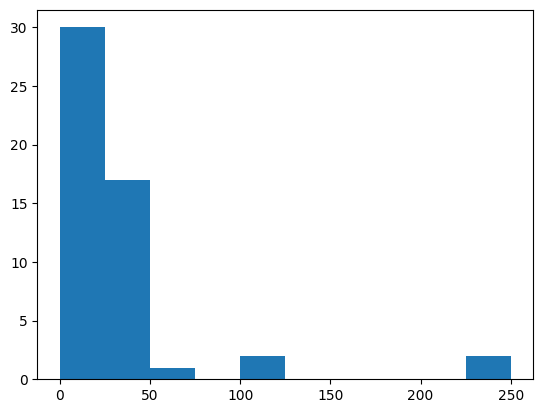

In [20]:
# looking at...price
df['price'].hist(grid=False)

<Axes: >

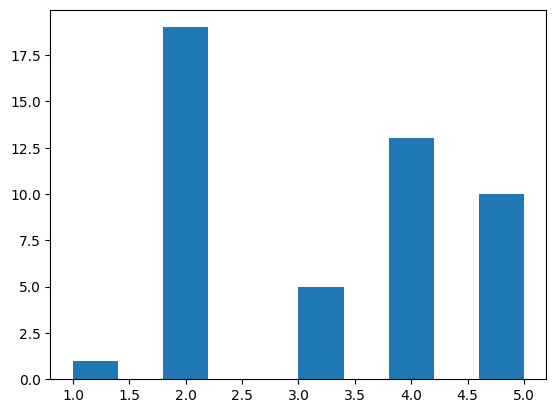

In [21]:
# looking at...condition
df['condition'].hist(grid=False)
# most of the conditions that we see are 'good'. 

<Axes: >

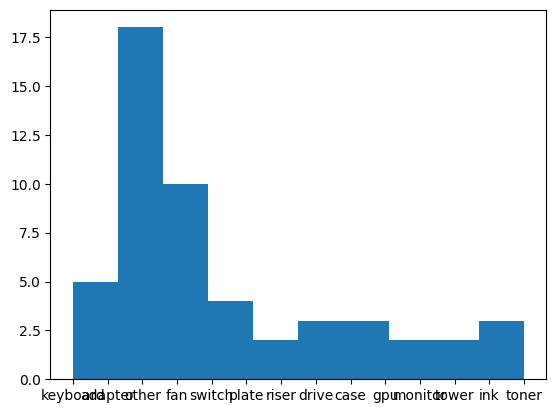

In [22]:
# looking at...item type
df['item'].hist(grid=False)
# ugly x axis but we don't need to beautify it so it doesn't matter. 

In [23]:
# some stratification/cross-tabulation of the data.
# price by item:
df.loc[:,['price','item']].groupby('item').describe()
# monitors are EXPENSIVE, but that goes without saying 
# 'other' is also expensive but we cannot really know what they are
# people be giving away their toner for FREE 

price                                                           
         count        mean         std   min    25%    50%     75%    max
item                                                                     
adapter    4.0   15.000000    9.128709   5.0   8.75   15.0   21.25   25.0
case       1.0    5.000000         NaN   5.0   5.00    5.0    5.00    5.0
drive      3.0   21.666667   10.408330  10.0  17.50   25.0   27.50   30.0
fan       10.0   21.500000    9.442810  10.0  12.50   25.0   25.00   40.0
gpu        2.0   70.000000   70.710678  20.0  45.00   70.0   95.00  120.0
ink        2.0    5.000000    7.071068   0.0   2.50    5.0    7.50   10.0
keyboard   1.0   25.000000         NaN  25.0  25.00   25.0   25.00   25.0
monitor    2.0  135.000000  162.634560  20.0  77.50  135.0  192.50  250.0
other     18.0   38.777778   59.328156  10.0  15.00   20.0   25.00  250.0
plate      2.0   12.500000    3.535534  10.0  11.25   12.5   13.75   15.0
riser      2.0   20.000000   14.142136  10.0  15.00   20.0   25.00   30.0
switch     2.0   25.000000    7.071068  20.0  22.50   25.0   27.50   30.0
toner      1.0    0.000000         NaN   0.0   0.00    0.0    0.00    0.0
tower      2.0   25.000000    0.000000  25.0  25.00   25.0   25.00   25.0

In [24]:
# price by condition:
df.loc[:,['price','condition']].groupby('condition').describe()
# price does not seem positively correlated with condition. 
# seems almost quadriatic?
# but there's probably a confounding variable (such as item type) that...
# ...causes this variation. 

price                                                      
          count       mean         std   min   25%   50%   75%    max
condition                                                            
1.0         1.0  20.000000         NaN  20.0  20.0  20.0  20.0   20.0
2.0        19.0  23.052632   27.695715   5.0  10.0  15.0  22.5  123.0
3.0         5.0  68.000000  101.771804  20.0  20.0  25.0  25.0  250.0
4.0        13.0  21.153846    7.403222  10.0  15.0  25.0  25.0   30.0
5.0        10.0  19.000000   11.498792   0.0  10.0  22.5  25.0   40.0

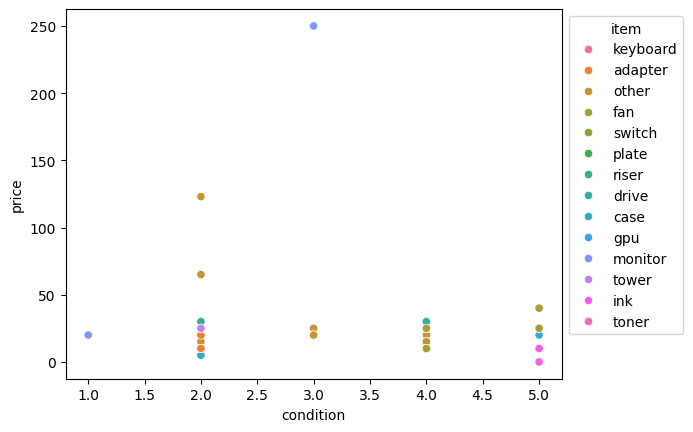

In [25]:
# a basic scatterplot 
ax = sns.scatterplot(data=df, x='condition', y='price',hue='item')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

### Some observations/EDA 
- Most people seem unwilling to sell items in 'fair' conditions, but plenty of people are willing to sell items that are in 'good' or even 'like new' conditions. They're probably aware that computer parts in worse conditions won't function; nobody would want to buy them anyways. They're not too lucrative of an opportunity.
- I find it a little strange that people are willing to sell items from right out the package. There is also a pattern amongst these new items - they are typically fans or ink, according to my scatterplot. After taking a cursory glance at the Craigslist listings themselves, seems like the "new fans for sale" registered by my computer are actually fan *decals* - they probably came with other computer parts, and the sellers saw no need for them anymore. (Similarly, I think the new ink people are selling is ink people bought with something else but didn't need.)
- Our scatterplot goes to show just how expensive decent monitors are - the monitor in 'excellent' condition goes for over $250, but the monitor in 'fair' condition is closer to the average price of the rest of the listings. 